In [2]:
import calendar
from copy import deepcopy
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
%matplotlib inline

### Download data

In [4]:
datapath = Path('../data/mhp_test_task/')

In [5]:
df = pd.read_csv(Path(datapath / 'sales_data.csv'))
df.head()

,date,product_id,product_name,category,quantity,price,total_revenue
0,2022-01-01,101,Product A,Category 1,2,10.0,20.0
1,2022-01-02,102,Product B,Category 1,1,15.0,15.0
2,2022-01-03,103,Product C,Category 2,5,7.0,35.0
3,2022-01-04,104,Product D,Category 3,10,3.0,30.0
4,2022-02-01,101,Product A,Category 1,3,10.0,30.0


### Explore data

In [6]:
df.shape

(26, 7)

See if there are any null values

In [7]:
pd.isnull(df).sum()

date             0
product_id       0
product_name     0
category         0
quantity         0
price            0
total_revenue    0
dtype: int64

See data types for each feature. It seems like the Date column should be converted to datetime format

In [8]:
df.dtypes

date              object
product_id         int64
product_name      object
category          object
quantity           int64
price            float64
total_revenue    float64
dtype: object

In [9]:
df.describe()

,product_id,quantity,price,total_revenue
count,26.000000,26.000000,26.000000,26.000000
mean,103.192308,4.038462,12.384615,41.038462
std,1.720912,2.505686,7.122230,28.518739
min,101.000000,1.000000,3.000000,12.000000
25%,102.000000,2.000000,7.000000,20.000000
50%,103.000000,4.000000,10.000000,30.000000
75%,104.750000,5.000000,18.750000,54.500000
max,106.000000,10.000000,25.000000,125.000000


#### Get unique values of the categorical features

In [10]:
df['product_name'].value_counts()

product_name
Product A    6
Product C    5
Product B    4
Product D    4
Product E    4
Product F    3
Name: count, dtype: int64

In [11]:
df['category'].value_counts()

category
Category 1    10
Category 2     9
Category 3     7
Name: count, dtype: int64

#### View data distribution with box and whiskers

It seems like there is no outliers

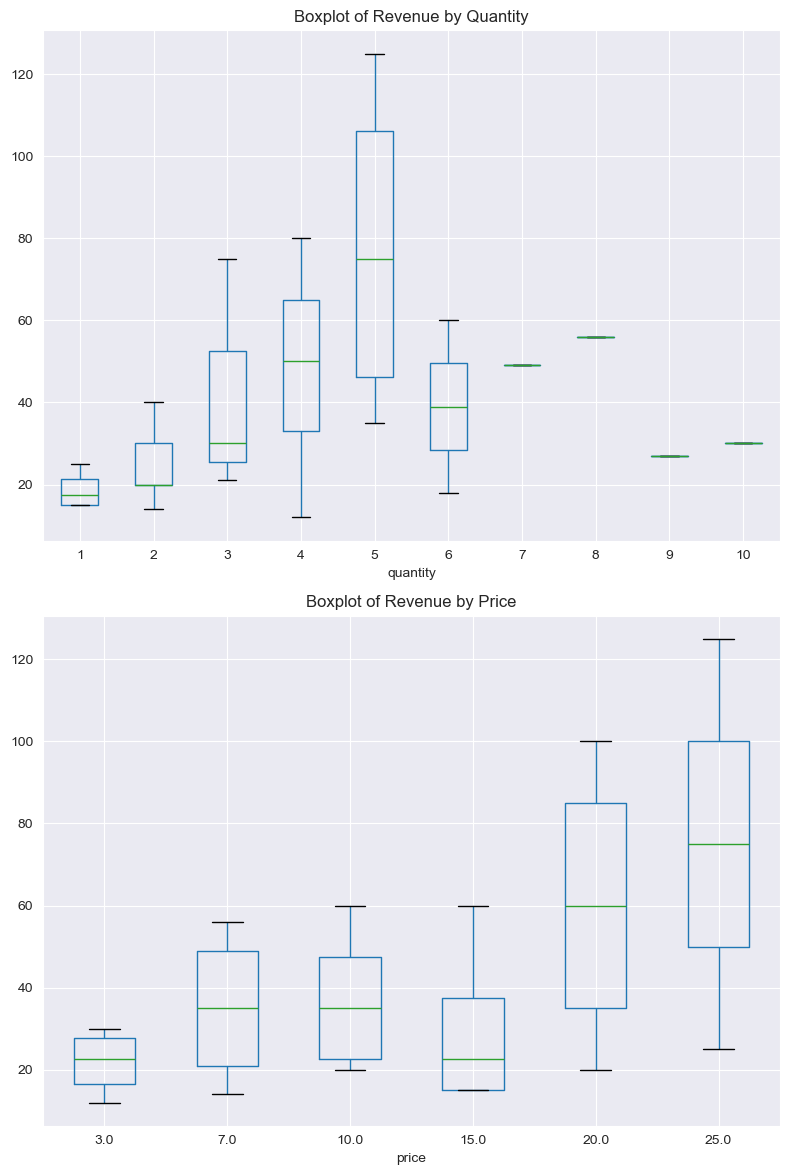

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

df.boxplot(column='total_revenue', by='quantity', vert=True, ax=ax1, showfliers=True)
ax1.set_title('Boxplot of Revenue by Quantity')
ax1.grid(True)

df.boxplot(column='total_revenue', by='price', vert=True, ax=ax2, showfliers=True)
ax2.set_title('Boxplot of Revenue by Price')
ax2.grid(True)

ax1.get_figure().suptitle('')
ax2.get_figure().suptitle('')

plt.tight_layout()
plt.show()

### Transform data

Function to transform datetime to specific format

In [13]:
def transform_datetime_data(df, feature_name, format):
    df[feature_name] = pd.to_datetime(df[feature_name], format=format)
    return df

Function to round float values to specific decimals

In [14]:
def round_floats(df, feature_name, n_round):
    df[feature_name] = df[feature_name].apply(lambda x: round(x, n_round))
    return df

In [15]:
date_format = '%Y-%m-%d'
df = transform_datetime_data(df, 'date', date_format)
df['date'].dt.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [16]:
df = round_floats(df, 'price', 2)
df = round_floats(df, 'total_revenue', 2)

### Data analysis

#### Get total revenue

In [17]:
total_revenue = df['total_revenue'].sum()
total_revenue

1067.0

#### Mean revenue per transaction

In [18]:
round(df['total_revenue'].mean(), 3)

41.038

#### Most popular products by number of transactions and total revenue

In [19]:
df.groupby('product_name')['total_revenue'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)

,sum,count
product_name,,
Product E,240.0,4
Product F,225.0,3
Product A,220.0,6
Product C,175.0,5
Product B,120.0,4
Product D,87.0,4


#### Search for season trends

Function to add a new column - a string representation of the month. 
It is specifically used for task of finding season trends.

In [20]:
def insert_new_column(df, col_pos, col_name, data):
    try:
        df.insert(col_pos, col_name, data)
        return df
    except ValueError:
        return df

Find revenue per month, convert into DataFrame and add a new column with month names

In [21]:
revenue_per_month = df.groupby(df['date'].dt.month)['total_revenue'].sum()
revenue_per_month = pd.DataFrame(revenue_per_month, columns=['total_revenue']).rename_axis('month')
revenue_per_month = insert_new_column(revenue_per_month, 0, 'month_name', revenue_per_month.index)

In [22]:
revenue_per_month['month_name'] = revenue_per_month['month_name'].apply(lambda x: calendar.month_name[x])

In [23]:
revenue_per_month.sort_values(by='total_revenue', ascending=False)

,month_name,total_revenue
month,,
10,October,185.0
5,May,118.0
2,February,110.0
1,January,100.0
4,April,89.0
6,June,89.0
9,September,81.0
11,November,76.0
7,July,65.0


#### Functions to make plots

In [24]:
def plot_bar(df, target, labels, title):
    min = df[target].min()
    max = df[target].max()
    mean = df[target].mean()
    
    plt.figure(figsize=(10, 6))
        
    plt.bar(labels, df[target], color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid()
    
    plt.axhline(y=min, color='red', linestyle='--', linewidth=2, label=f'Min Value: {min}')
    plt.axhline(y=max, color='green', linestyle='--', linewidth=2, label=f'Max Value: {max}')
    plt.axhline(y=mean, color='yellow', linestyle='-.', linewidth=2, label=f'Mean Value: {mean:.2f}')
    
    plt.legend(loc="upper right")
    plt.show()

In [25]:
def plot_pie(df, target, labels, title):
    min_value = df[target].min()
    max_value = df[target].max()
    mean_value = df[target].mean()
    
    explode = [0.2 if (val == min_value or val == max_value) else 0.05 for val in df[target]]
    
    plt.figure(figsize=(10, 8))
    plt.pie(df[target], 
            labels=labels, 
            autopct='%1.1f%%', 
            explode=explode, 
            startangle=90, 
            colors=plt.cm.tab20.colors)
    
    plt.title(title)
    plt.legend([f'Min Value: {min_value}', f'Max Value: {max_value}', f'Mean Value: {mean_value:.2f}'], loc="upper right")
    plt.show()

Barplot of a distribution of revenue per months

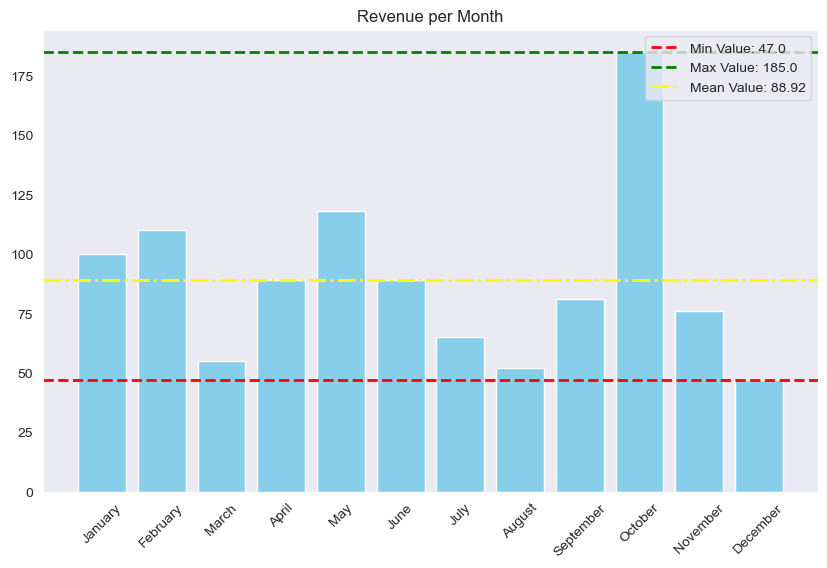

In [26]:
plot_bar(df=revenue_per_month,
         target='total_revenue', 
         labels=revenue_per_month['month_name'], 
         title='Revenue per Month')

Pie chart of a distribution of revenue per months

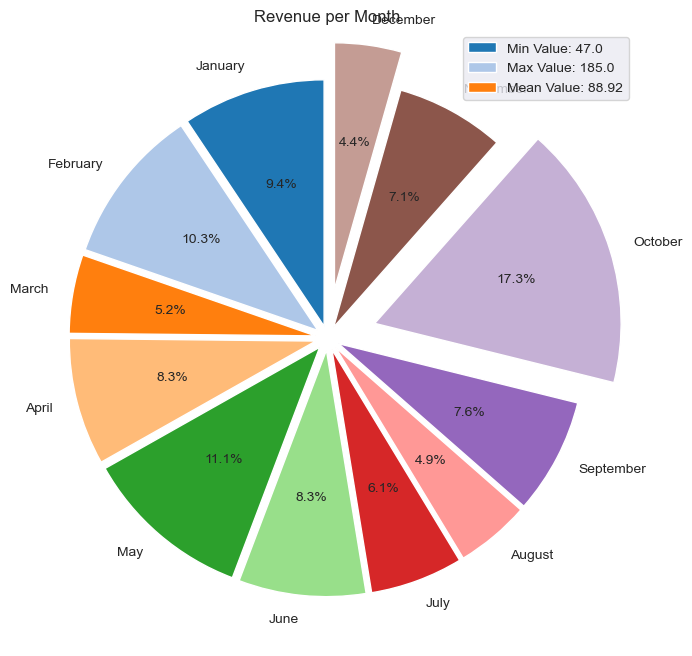

In [27]:
plot_pie(df=revenue_per_month,
         target='total_revenue', 
         labels=revenue_per_month['month_name'], 
         title='Revenue per Month')

### Product categories analysis

#### Sales per product category

Find total revenue per product

In [28]:
product_sales = pd.DataFrame(df.groupby('product_name')['total_revenue'].sum().reset_index())

In [29]:
product_sales.sort_values(by='total_revenue', ascending=False)

,product_name,total_revenue
4,Product E,240.0
5,Product F,225.0
0,Product A,220.0
2,Product C,175.0
1,Product B,120.0
3,Product D,87.0


Barplot of a distribution of revenue per product

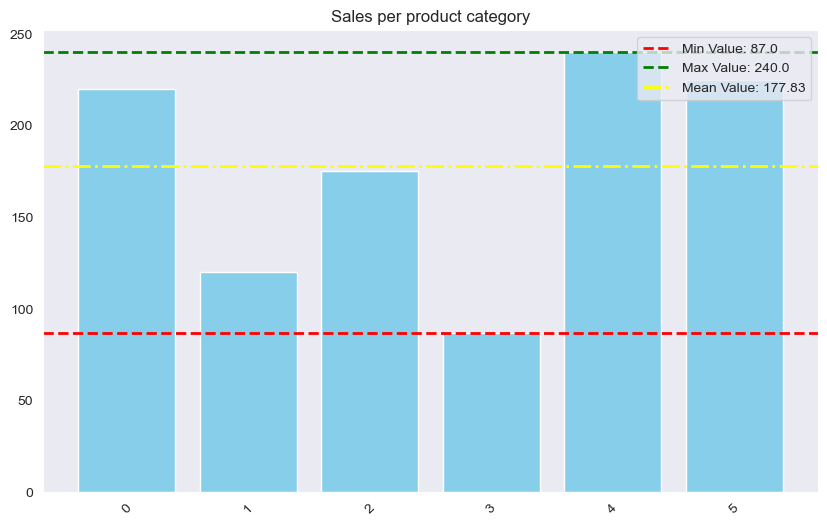

In [30]:
plot_bar(df=product_sales,
         target='total_revenue',
         labels=product_sales.index.tolist(), 
         title='Sales per product category')

#### Product categories rate in total revenue

Find a rate of sales of each product in whole sales

In [31]:
sales = df['total_revenue'].sum()
df.groupby('product_name')['total_revenue'].agg('sum').apply(lambda x: round(x / sales, 3))

product_name
Product A    0.206
Product B    0.112
Product C    0.164
Product D    0.082
Product E    0.225
Product F    0.211
Name: total_revenue, dtype: float64

Plot a pie chart of a distribution of sales per product

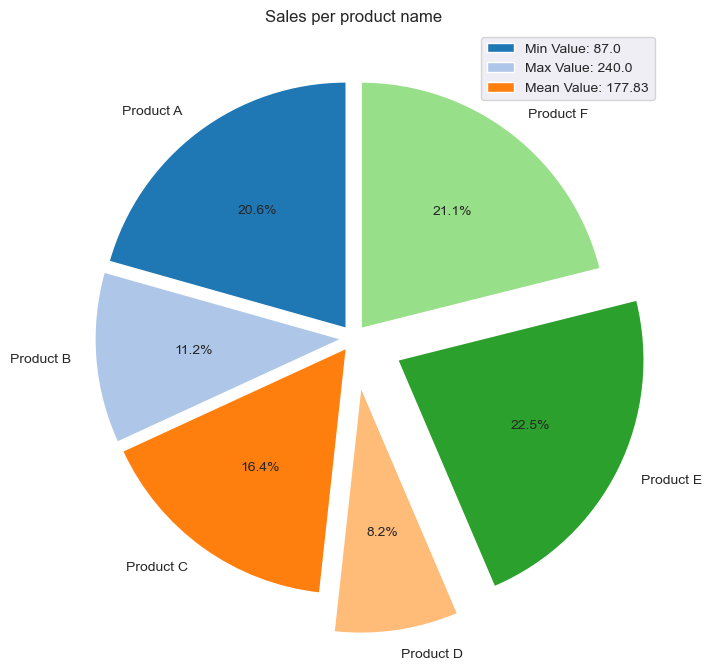

In [32]:
plot_pie(df=product_sales,
         target='total_revenue',
         labels=product_sales['product_name'], 
         title='Sales per product name')

Plot a pie chart of a distribution of sales per category

In [33]:
categories_sales = pd.DataFrame(df.groupby('category')['total_revenue'].sum().reset_index())

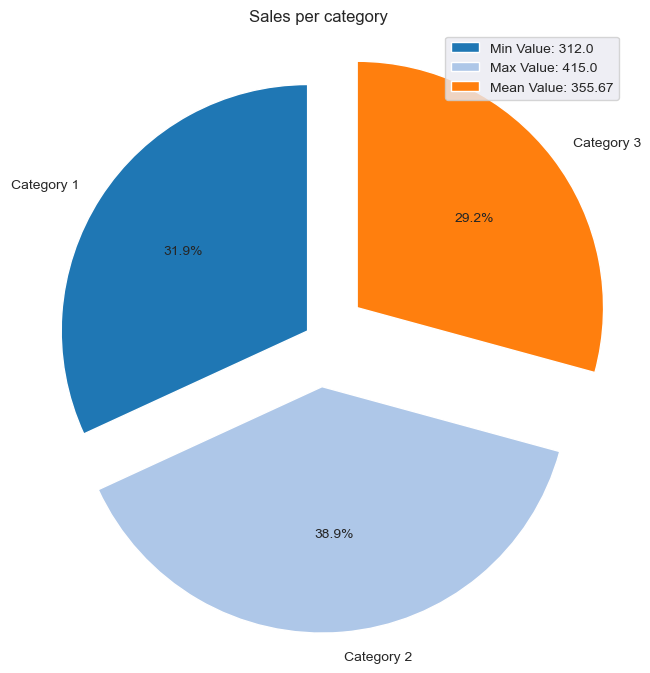

In [34]:
plot_pie(df=categories_sales,
         target='total_revenue',
         labels=categories_sales['category'], 
         title='Sales per category')

### View dependencies

#### Dependency between prices and quantity 

Based on this plot we can see that the cheaper products are better sold. 
But it is not enough, we should see the dependency between price and quantity for different product categories 

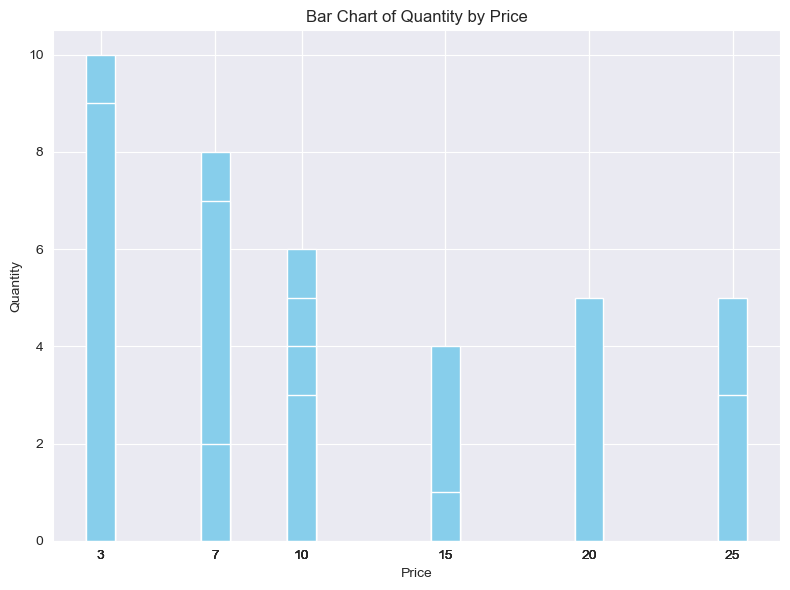

In [35]:
plt.figure(figsize=(8, 6))

df_sorted_by_price = df.sort_values(by='price')
plt.bar(df_sorted_by_price['price'], df_sorted_by_price['quantity'], width=1, color='skyblue')

plt.xlabel('Price')
plt.ylabel('Quantity')

plt.title('Bar Chart of Quantity by Price')
plt.grid(True)

plt.xticks(df_sorted_by_price['price'])
plt.tight_layout()

plt.show()

Let's see the rate of each price step in the total of sales (quantity of purchases)

In [36]:
grouped_by_price_and_quantity = df.groupby('price')['quantity'].sum().reset_index()

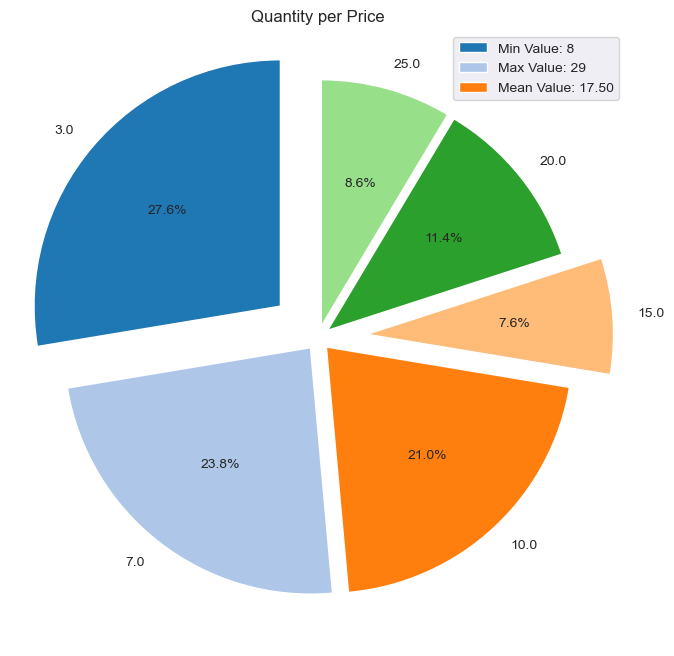

In [37]:
plot_pie(df=grouped_by_price_and_quantity,
         target='quantity', 
         labels=grouped_by_price_and_quantity['price'], 
         title='Quantity per Price')

#### Dependency between prices and quantity for categories and products

Now let's see the dependency between price and quantity for different product categories

In [38]:
categories = df.groupby(['category', 'price'])['quantity'].sum().reset_index()
product_types = df.groupby(['product_name', 'price'])['quantity'].sum().reset_index()

Here is the general function to create a barplot for grouped data.
In this section the function serves to visualize the stacked barplot to see price / quantity distribution for all categories or product types

In [39]:
def plot_grouped_dependencies(df, target_value, target_type, subset_1, subset_2):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    for i, elem in enumerate(df[target_value].unique()):
        subset = df[df[target_value] == elem]
        ax.bar(subset[subset_1], subset[subset_2], label=elem, color=colors[i])
    
    ax.set_xlabel(subset_1)
    ax.set_ylabel(subset_2)
    ax.set_title(f'{subset_2} for {subset_1}')
    ax.legend(title=target_type)
    ax.grid(True)
    
    plt.tight_layout()
    
    plt.show()

Let's vizualize the stacked barplot for categories

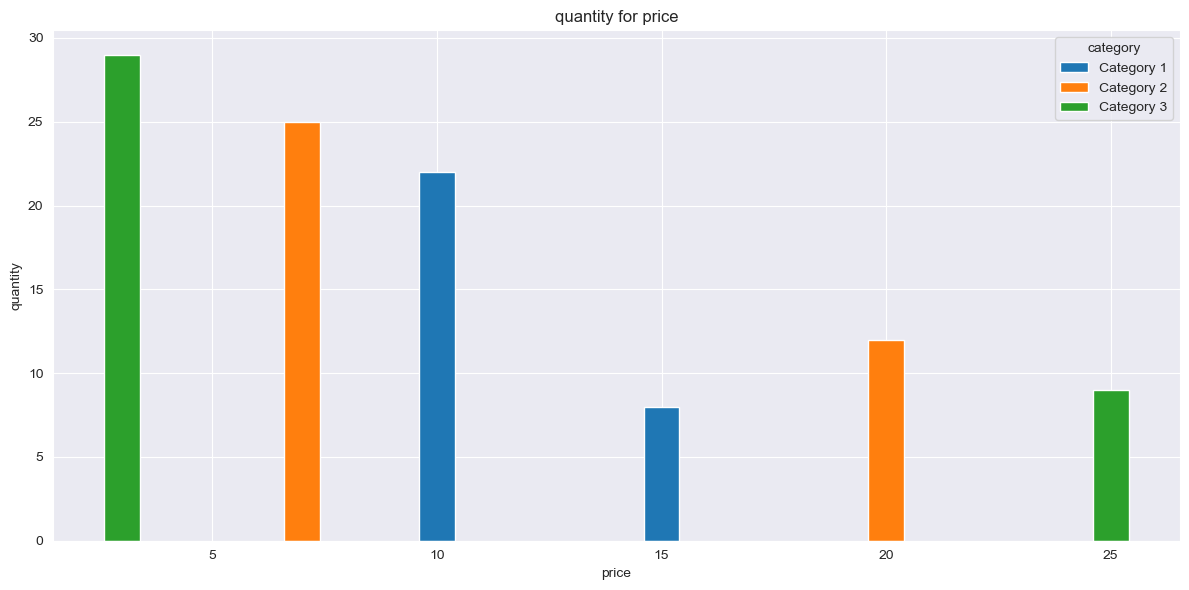

In [40]:
plot_grouped_dependencies(df=categories,
                          target_value='category', 
                          target_type='category', 
                          subset_1='price',
                          subset_2='quantity')

Let's vizualize the stacked barplot for products

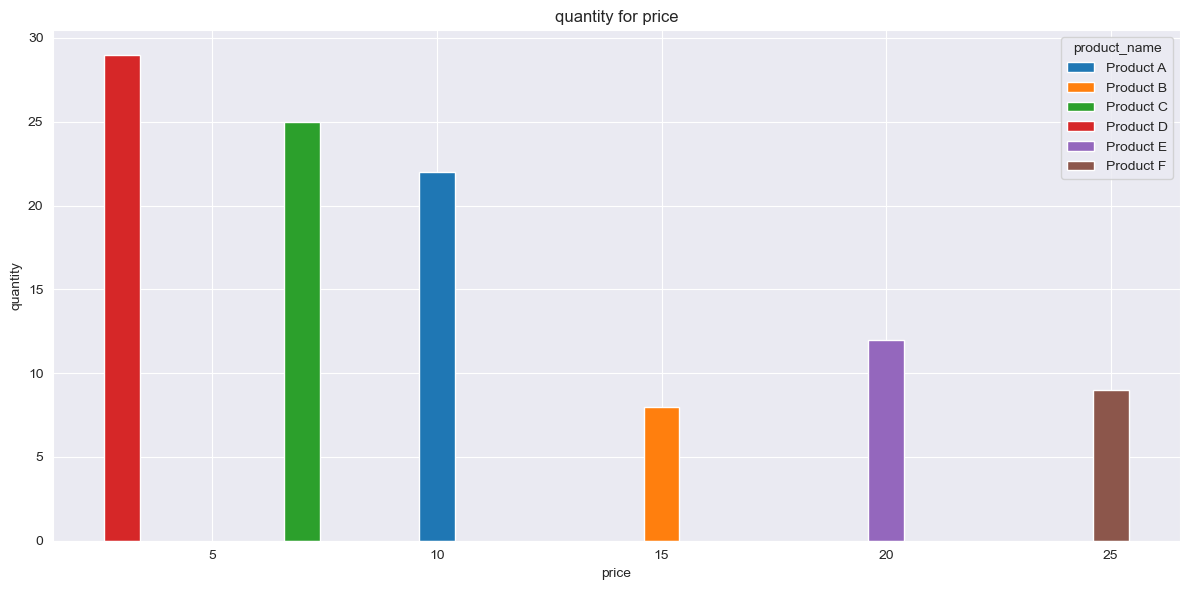

In [41]:
plot_grouped_dependencies(df=product_types, 
                          target_value='product_name', 
                          target_type='product_name', 
                          subset_1='price', 
                          subset_2='quantity')

#### Dependency between sales per month for categories and products

In this section we will view the dependency between period (month) and revenue for each category and product type

Let's group data (months and revenue) for categories.
For plotting we will use the previously defined function 'plot_grouped_dependencies()'

Define a function to fill the missing sales for a category per month. E.g., in 2nd month we have sales only for Category 1 and Category 2. So, we add the line for Category 3 for this month and set the revenue for it = 0. We do this to avoid mishing the dates when plotting the barplot.

In [42]:
def fill_missing_cats_per_month(df, target_value, unique_targets):
    unique_dates = df['year_month'].unique()
    
    for date in unique_dates:
        subframe = df[df['year_month'] == date][target_value]
    
        if len(subframe) < 3:
            for val in unique_targets:
                if val not in subframe.values:
                    new_line = pd.DataFrame({'year_month': [date], target_value: [val], 'total_revenue': [0]})
                    df = pd.concat([df, new_line], axis=0)
    return df

Make a deepcopy of original dataframe to avoid undesirable changes

In [43]:
df_sales_per_month = deepcopy(df[['date', 'category', 'product_name', 'total_revenue']])

Create a new column with data but only with year and month. So we will be looking for monthly trends

In [44]:
df_sales_per_month.loc[:, 'year_month'] = df_sales_per_month['date'].dt.to_period('M')

Make an aggregation

In [45]:
sales_per_month_cat = df_sales_per_month.groupby(['year_month', 'category'])['total_revenue'].sum().reset_index()

Get unique categories. It is needed for function 'fill_missing_cats_per_month()'

In [46]:
unique_categories = sales_per_month_cat['category'].unique()

Fill the missing sales for categories

In [47]:
sales_per_month_cat = fill_missing_cats_per_month(df=sales_per_month_cat, target_value='category', unique_targets=unique_categories)

Sort dataframe by dates to bring it to a relevant form. Also convert dates into string so that we could plot them.

In [48]:
sales_per_month_cat = sales_per_month_cat.sort_values(by='year_month', ascending=True)
sales_per_month_cat['year_month'] = sales_per_month_cat['year_month'].astype(str)

Plot the dataframe 

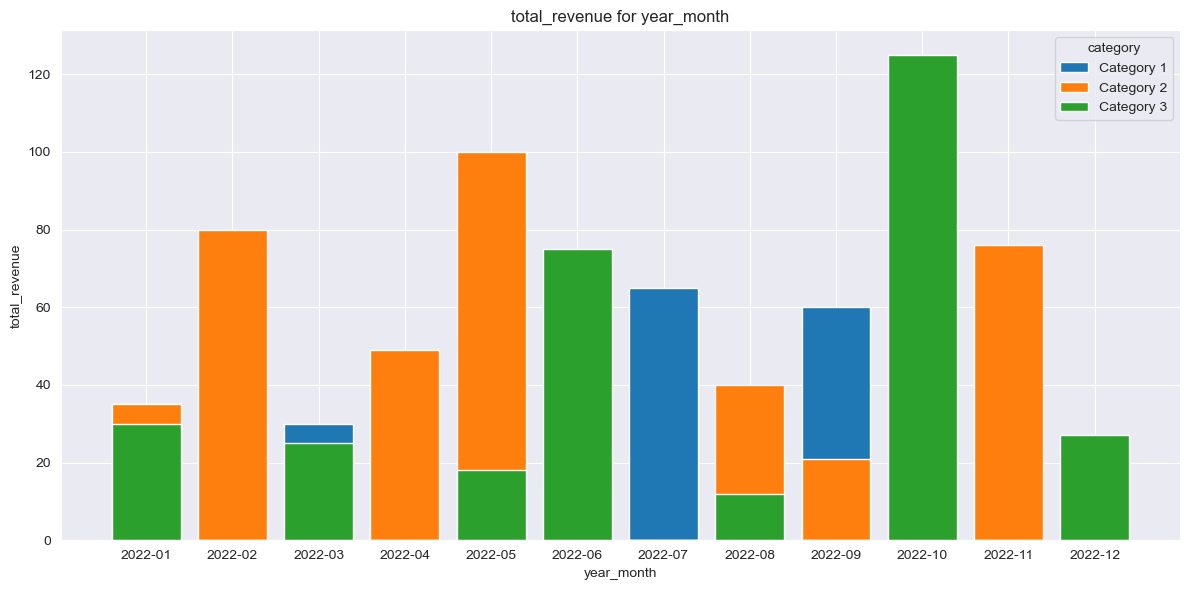

In [49]:
plot_grouped_dependencies(sales_per_month_cat, 'category', 'category', 'year_month', 'total_revenue')

Let's group data (months and revenue) for product types. For plotting we will use the previously defined function 'plot_grouped_dependencies()'

Below we do the same steps as for the plotting of the monthly sales per categories 

In [50]:
sales_per_month_prod = df_sales_per_month.groupby(['year_month', 'product_name'])['total_revenue'].sum().reset_index()
sales_per_month_prod['year_month'] = sales_per_month_prod['year_month'].astype(str)

In [51]:
unique_products = sales_per_month_prod['product_name'].unique()

In [52]:
sales_per_month_prod = fill_missing_cats_per_month(df=sales_per_month_prod, target_value='product_name', unique_targets=unique_products)

In [53]:
sales_per_month_prod = sales_per_month_prod.sort_values(by='year_month', ascending=True)
sales_per_month_prod['year_month'] = sales_per_month_prod['year_month'].astype(str)

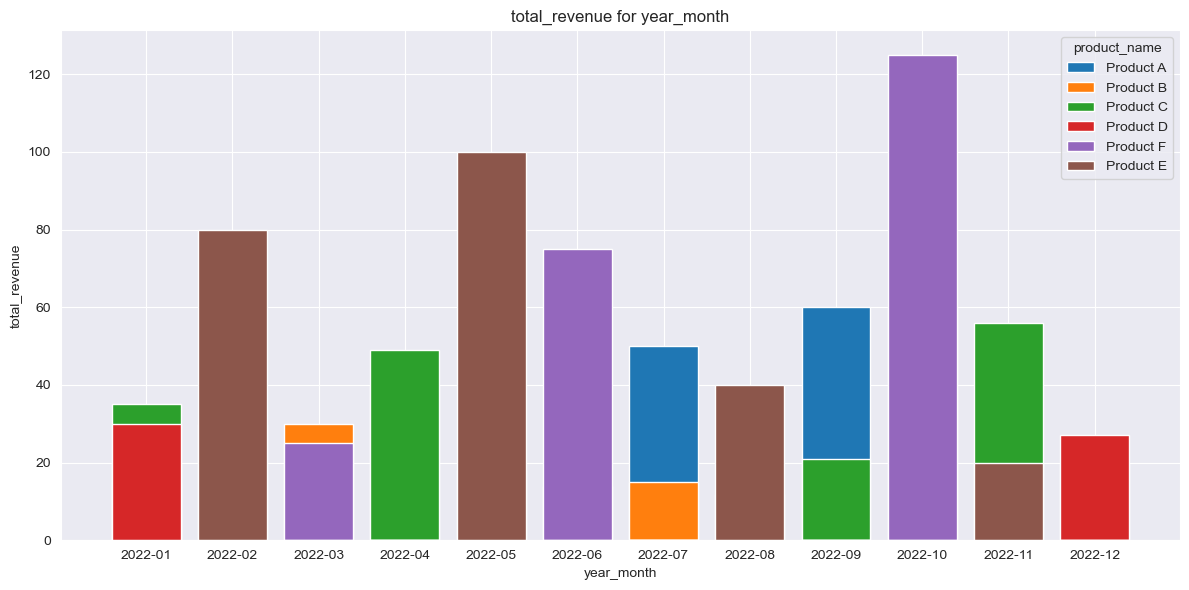

In [54]:
plot_grouped_dependencies(sales_per_month_prod, 'product_name', 'product_name', 'year_month', 'total_revenue')

### Summary

**Сезонность**

В розрізі продажів по місяцях є певна нерегулярність, але в цілому це не схоже на сезонність. Впадає у вічі нерівномірний продаж окремих видів продуктів і продуктових категорій. Але більше схоже не на сезонність, а на брак системності в роботі маркетингу і продажів. 

**Seasonality**

There is some irregularity in monthly sales, but overall it doesn't seem to be seasonal. The uneven sales of individual types of products and product categories stand out. However, it appears to be more due to a lack of systematic marketing and sales efforts rather than seasonality

**Ціни**

Найбільше за кількістю проданих товарів — товари в низькій ціновій категорії (3 та 7). Хороший показник має товар у середній ціновій категорії (10). Далі, зі зростанням цін, ситуація з обсягами продажів різко погіршується (для 15, 20 та 25).


**Prices**

The highest quantity of goods sold is in the low price category (3 and 7). The product in the mid-price category (10) has a good performance. As prices rise, the sales volumes sharply decline (for 15, 20, and 25).

**Категорії и продукти**

Продукти A, E і F приносять найбільший оборот. При цьому обсяги продажів E і F найнижчі, але вони мають найвищу ціну, завдяки чому й створюють оборот.

Продукт B явний аутсайдер – має середню цінову категорію і найнижчі обсяги продажів.

Категорії 3 і 2 мають найширший ціновий діапазон (продукти з високих і низьких цінових категорій). Категорія 1 за ціною найбільш центрована (обидва продукти із середньої цінової категорії).

Категорії 2 і 3 продаються майже постійно: мало місяців, в яких продукти цих категорій не продавалися б. Але при цьому всі 3 категорії мають майже рівні частки у загальному доході.

Постійність продажів цих категорій забезпечується дешевими продуктами (C, D), а оборот – дорогими (E, F).

Найцікавіший випадок – це категорія 1: всього за 2 місяці продажів ця категорія приносить третину всього обороту. Точніше, саме продукт A із цінової категорії = 10 робить цей оборот.


**Categories and products**

Products A, E, and F generate the most revenue. At the same time, the sales volumes of E and F are the lowest, but they have the highest prices, which is why they generate revenue.

Product B is a clear outsider - it has a mid-price category and the lowest sales volumes.

Categories 3 and 2 have the widest price range (products from high and low price categories). Category 1 is the most centered in price (both products are from the mid-price category).

Categories 2 and 3 sell almost constantly: there are few months in which products from these categories were not sold. However, all three categories have almost equal shares in the overall revenue.

The consistency of sales in these categories is ensured by cheap products (C, D), while the revenue is generated by expensive ones (E, F).

The most interesting case is category 1: in just 2 months of sales, this category generates a third of the total revenue. Specifically, it is product A from the price category = 10 that generates this revenue.

**Висновки**

На мій погляд, продукт A - найперспективніший. Якщо збільшити частоту його продажів, то він суттєво збільшить дохід компанії за рік.

Також має сенс переглянути стратегію по Категорії 1: можливо, варто залишити в цій категорії тільки продукт A і перенаправити ресурс на продаж продукту A. Знижувати ціну продукту B не бачу сенсу, оскільки це створить конкуренцію продукту A. Можливо, варто переглянути концепцію продукту B і перевести його в іншу цінову категорію.

Продукт D продається найкраще, але генерує всього 8% доходу. При цьому продукт F з тієї ж категорії (категорія 3) є найдорожчим. Це може призводити до непорозуміння у головах покупців. Можливо, варто вивести дешевий продукт в іншу категорію з іншим позиціонуванням.

Продукт E майже з тієї ж цінової категорії, що й F, але продається краще і приносить більший дохід.

Отже, є 3 продукти, які, незважаючи на невеликі обсяги продажів, генерують сумарно майже 64% доходу. Бачу сенс робити ставку на збільшення продажів саме цих 3-х видів продукту. Особливу ставку варто зробити на збільшення продажів продукту A. Паралельно варто переглянути стратегію щодо продуктів B і D.

**Conclusions**

In my opinion, product A is the most promising. If its sales frequency increases, it will significantly boost the company's annual revenue.

It also makes sense to review the strategy for Category 1: perhaps it is worth keeping only product A in this category and redirecting resources to selling product A. I don't see the point in lowering the price of product B, as this would create competition for product A. It might be worth rethinking the concept of product B and moving it to another price category.

Product D sells the best, but it generates only 8% of the revenue. Meanwhile, product F from the same category (category 3) is the most expensive. This might cause confusion in the minds of customers. It might be worth moving the cheap product to another category with different positioning.

Product E is almost in the same price category as F, but sells better and generates more revenue.

In summary, there are 3 products that, despite their low sales volumes, generate almost 64% of the revenue. I see the point in focusing on increasing the sales of these 3 types of products. Special emphasis should be placed on increasing the sales of product A. At the same time, the strategy for products B and D should be reviewed.